In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Try using 'ISO-8859-1' or 'latin1' encoding
Dataset = pd.read_csv('C:/Users/kaspe/Documents/GitHub/KCL_Eksamensprojekt/AI_Model_Training/data/20244281821457313338UHELDK129906013912.csv', names=column_names, sep=';', encoding='ISO-8859-1')

df = Dataset
df.head()

,Gender,Age,Type of Injury,Area,Type of Vehicle,2020,2021,2022
0,Mænd,0-17 år,Personskade i alt,Region Hovedstaden,Almindelig personbil,9,7,4
1,Mænd,0-17 år,Personskade i alt,Region Hovedstaden,Taxi,0,0,0
2,Mænd,0-17 år,Personskade i alt,Region Hovedstaden,Køretøj 0-3.500 kg under udrykning,0,0,0
3,Mænd,0-17 år,Personskade i alt,Region Hovedstaden,Varebil 0-3.500 kg.,0,1,0
4,Mænd,0-17 år,Personskade i alt,Region Hovedstaden,Lastbil over 3.500 kg.,0,0,0


In [45]:
# Manually specifying column names
column_names = ['Gender', 'Age', 'Type of Injury', 'Area', 'Type of Vehicle', '2020', '2021', '2022']

# Proceed with the data preparation

# Merge 'Knallert' and 'Knallert 45' into 'Knallert'
df['Type of Vehicle'] = df['Type of Vehicle'].replace(['Knallert 45'], 'Knallert')

# Sum the incidents from 2020, 2021, 2022 into a single 'Total Incidents' column
df['Total Incidents'] = df[['2020', '2021', '2022']].sum(axis=1)

# Drop the now unnecessary year columns
df.drop(['2020', '2021', '2022'], axis=1, inplace=True)

# Create a copy of the dataframe for encoding
df_encoded = df.copy()

# Initialize a label encoder for each categorical column
label_encoders = {}
for column in ['Gender', 'Age', 'Type of Injury', 'Area', 'Type of Vehicle']:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column])
    label_encoders[column] = le

# Now, `df_encoded` contains integers instead of string categories


In [46]:
df.head()

,Gender,Age,Type of Injury,Area,Type of Vehicle,Total Incidents
0,Mænd,0-17 år,Personskade i alt,Region Hovedstaden,Almindelig personbil,20
1,Mænd,0-17 år,Personskade i alt,Region Hovedstaden,Taxi,0
2,Mænd,0-17 år,Personskade i alt,Region Hovedstaden,Køretøj 0-3.500 kg under udrykning,0
3,Mænd,0-17 år,Personskade i alt,Region Hovedstaden,Varebil 0-3.500 kg.,1
4,Mænd,0-17 år,Personskade i alt,Region Hovedstaden,Lastbil over 3.500 kg.,0


In [47]:
df_encoded

,Gender,Age,Type of Injury,Area,Type of Vehicle,Total Incidents
0,1,0,3,0,0,20
1,1,0,3,0,9,0
2,1,0,3,0,6,0
3,1,0,3,0,10,1
4,1,0,3,0,7,0
...,...,...,...,...,...,...
4315,2,5,2,2,5,0
4316,2,5,2,2,5,0
4317,2,5,2,2,3,0
4318,2,5,2,2,4,0


In [48]:
# Define the number of folds for cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Prepare arrays to store results
fold_no = 1
loss_per_fold = []

# K-fold Cross Validation model evaluation
for train, test in kf.split(X, y):
    # Define the model architecture
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1)  # Output layer
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    
    # Generate a print
    print(f'Training for fold {fold_no} ...')
    
    # Fit data to model
    history = model.fit(X.iloc[train], y.iloc[train],
                        validation_data=(X.iloc[test], y.iloc[test]),
                        epochs=100,
                        batch_size=32,
                        verbose=0)  # Set verbose to 0 for less output
    
    # Generate generalization metrics
    scores = model.evaluate(X.iloc[test], y.iloc[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores:.4f}')
    loss_per_fold.append(scores)
    
    # Increase fold number
    fold_no += 1

# == Provide average scores ==
print('----------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(loss_per_fold)):
  print('----------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]}')
print('----------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('----------------------------------------------------------------')

Training for fold 1 ...
Score for fold 1: loss of 41.0770
Training for fold 2 ...
Score for fold 2: loss of 57.5567
Training for fold 3 ...
Score for fold 3: loss of 68.9192
Training for fold 4 ...
Score for fold 4: loss of 48.0270
Training for fold 5 ...
Score for fold 5: loss of 53.5863
----------------------------------------------------------------
Score per fold
----------------------------------------------------------------
> Fold 1 - Loss: 41.07698440551758
----------------------------------------------------------------
> Fold 2 - Loss: 57.55674743652344
----------------------------------------------------------------
> Fold 3 - Loss: 68.91920471191406
----------------------------------------------------------------
> Fold 4 - Loss: 48.027000427246094
----------------------------------------------------------------
> Fold 5 - Loss: 53.58632278442383
----------------------------------------------------------------
Average scores for all folds:
> Loss: 53.833251953125
----------

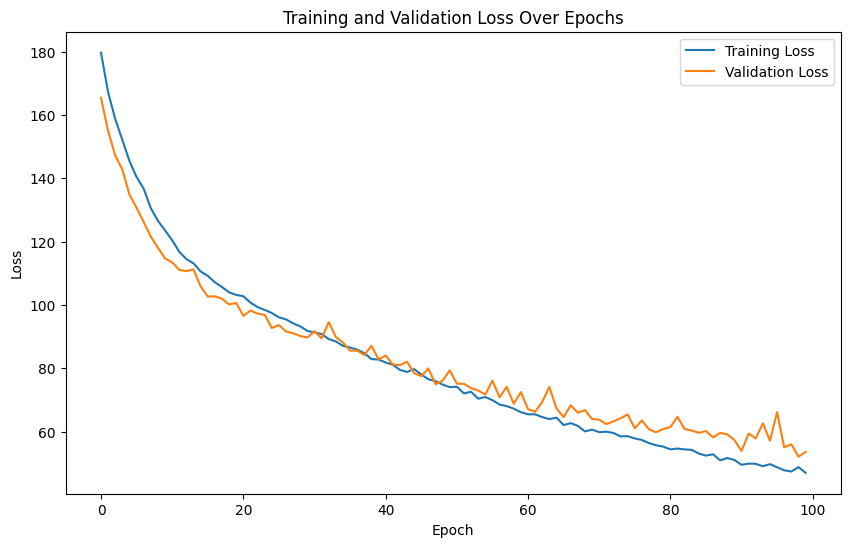

In [49]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [55]:
# Example new_data (ensure it's preprocessed as per your model's training data)
# 1	0	3	0	10	1
new_data = [[1, 0, 3, 0, 7]]  # An example input array corresponding to ['Gender', 'Age', 'Type of Injury', 'Area', 'Type of Vehicle']

# Assuming the column names and order are ['Gender', 'Age', 'Type of Injury', 'Area', 'Type of Vehicle']
columns = ['Gender', 'Age', 'Type of Injury', 'Area', 'Type of Vehicle']
new_data_df = pd.DataFrame(new_data, columns=columns)

predictions = model.predict(new_data)

# Predict
predictions = model.predict(new_data_df)

print(predictions)  # This will output the predicted total incidents for the new data


1/1 [==============================] - 0s 22ms/step
[[3.7015712]]


In [56]:
# Assuming 'df' is your dataset
average_incidents = df['Total Incidents'].mean()

# Assuming 'new_data_df' is a new DataFrame with the same structure as your training data
# And that you've already applied necessary preprocessing
predictions = model.predict(new_data_df)

# Example for one prediction
predicted_incidents = predictions[0]  # Assuming this is the predicted total incidents for the first activity
consequence_factor = 1  # Adjust based on your understanding of severity

# Calculate the risk score
risk_score = (predicted_incidents / average_incidents) * consequence_factor

print(f"Risk Score for the activity: {risk_score}")


1/1 [==============================] - 0s 21ms/step
Risk Score for the activity: [0.9331692]
